In [1]:
!pip install PySastrawi

     |████████████████████████████████| 215kB 6.7MB/s 


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import Sastrawi

In [3]:
#DATASET SOURCE FROM https://github.com/dbrehmer/Knowself/blob/master/data/mypersonality/essays.csv"
#DATASET USED IN THIS NOTEBOOK IS DATASET FROM THE SOURCE THAT HAS BEEN TRANSLATED TO BAHASA INDONESIA USING GOOGLE TRANSLATE

DATASET_URL = "https://raw.githubusercontent.com/lazuardi100/Hexa-Engineer/ML/Dataset/dataset.csv"
df = pd.read_csv(DATASET_URL, sep =',')

df.head()

,#AUTHID,TTEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Nah, sekarang saya baru saja bangun dari tidur...",n,y,y,n,y
1,1997_605191.txt,"Nah, di sini kita pergi dengan arus kesadaran ...",n,n,y,n,n
2,1997_687252.txt,Keyboard terbuka dan tombol untuk mendorong. H...,n,y,n,y,y
3,1997_568848.txt,Aku tidak percaya itu! Ini benar-benar terjadi...,y,n,y,y,n
4,1997_688160.txt,"Nah, di sini aku pergi dengan aliran tua yang ...",y,n,y,n,y


In [4]:
def changeLabel(labels):
  for index, values in enumerate(labels.values):
    if values == 'n':
      labels[index] = 0
    else:
      labels[index] = 1
  return labels

changeLabel(df['cEXT'])
changeLabel(df['cNEU'])
changeLabel(df['cAGR'])
changeLabel(df['cCON'])
changeLabel(df['cOPN'])

0       1
1       0
2       1
3       0
4       1
       ..
2462    0
2463    1
2464    0
2465    1
2466    1
Name: cOPN, Length: 2467, dtype: object

In [5]:
#Text Preprocessing referenced from https://github.com/ksnugroho/basic-text-preprocessing/blob/master/text-preprocessing.ipynb
import string
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def preprocess_text(text):
  #lowercase all character in the text
  text = text.lower()
  #remove punctuation
  text = text.translate(str.maketrans("","",string.punctuation))
  #remove leading and trailing whitespace
  text = text.strip()
  #remove StopWord
  stopword = StopWordRemoverFactory().create_stop_word_remover()
  text = stopword.remove(text)
  #stemming
  stemmer = StemmerFactory().create_stemmer()
  text = stemmer.stem(text)
  return text

df['TTEXT'] = df['TTEXT'].map(preprocess_text)

In [6]:
df = df.sample(frac=1)
train_dataset, val_dataset, test_dataset = np.split(df, [int(.95 * len(df)), int(.975 * len(df))])

In [7]:
train_data = train_dataset['TTEXT']
train_label_ext  = train_dataset['cEXT']
train_label_neu  = train_dataset['cNEU']
train_label_agr  = train_dataset['cAGR']
train_label_con  = train_dataset['cCON']
train_label_opn  = train_dataset['cOPN']

val_data = val_dataset['TTEXT']
val_label_ext  = val_dataset['cEXT']
val_label_neu  = val_dataset['cNEU']
val_label_agr  = val_dataset['cAGR']
val_label_con  = val_dataset['cCON']
val_label_opn  = val_dataset['cOPN']

test_data = test_dataset['TTEXT']
test_label_ext  = test_dataset['cEXT']
test_label_neu  = test_dataset['cNEU']
test_label_agr  = test_dataset['cAGR']
test_label_con  = test_dataset['cCON']
test_label_opn  = test_dataset['cOPN']

In [8]:
#Exploring Data

import statistics
word_counts = []
for data in train_data:
  word_count = len(data.split())
  word_counts.append(word_count)
print("mean: ",statistics.mean(word_counts))
print("median: ",statistics.median(word_counts))
print("max: ",max(word_counts))
print("min: ",min(word_counts))

mean:  199.14127187366623
median:  190
max:  714
min:  8


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Tried to use parameter and model from the NLP Course by Deeplearning.ai
vocab_size = 10000
embedding_dim = 16
max_length = 600
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data)

training_sequences = tokenizer.texts_to_sequences(train_data)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_data)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_data)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
#Create Data Pipeline

train_dataset_ext_2 = tf.data.Dataset.from_tensor_slices((training_padded, train_label_ext.values.astype(dtype=np.float32)))
train_dataset_ext = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_ext.values.astype(dtype=np.float32)))
train_dataset_neu = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_neu.values.astype(dtype=np.float32)))
train_dataset_agr = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_agr.values.astype(dtype=np.float32)))
train_dataset_con = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_con.values.astype(dtype=np.float32)))
train_dataset_opn = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_opn.values.astype(dtype=np.float32)))

val_dataset_ext_2 = tf.data.Dataset.from_tensor_slices((val_padded, val_label_ext.values.astype(dtype=np.float32)))
val_dataset_ext = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_ext.values.astype(dtype=np.float32)))
val_dataset_neu = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_neu.values.astype(dtype=np.float32)))
val_dataset_agr = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_agr.values.astype(dtype=np.float32)))
val_dataset_con = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_con.values.astype(dtype=np.float32)))
val_dataset_opn = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_opn.values.astype(dtype=np.float32)))

test_dataset_ext_2 = tf.data.Dataset.from_tensor_slices((test_padded, test_label_ext.values.astype(dtype=np.float32)))
test_dataset_ext = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_ext.values.astype(dtype=np.float32)))
test_dataset_neu = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_neu.values.astype(dtype=np.float32)))
test_dataset_agr = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_agr.values.astype(dtype=np.float32)))
test_dataset_con = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_con.values.astype(dtype=np.float32)))
test_dataset_opn = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_opn.values.astype(dtype=np.float32)))

In [20]:
embedding = "https://tfhub.dev/google/nnlm-id-dim128/2"

hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

model_ext = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, 1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')])

model_ext_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_ext_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model_ext.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               112461824 
_________________________________________________________________
lambda (Lambda)              (None, 1, 128)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 64)             41216     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [19]:
batch_size = 128
num_examples = tf.data.experimental.cardinality(train_dataset_ext).numpy()

ext_batches = train_dataset_ext.shuffle(num_examples // 4).batch(batch_size).prefetch(1)
ext_batches_2 = train_dataset_ext_2.shuffle(num_examples // 4).batch(batch_size).prefetch(1)

val_batches = val_dataset_ext.batch(batch_size).prefetch(1)
val_batches_2 = val_dataset_ext_2.batch(batch_size).prefetch(1)

test_batches = test_dataset_ext.batch(batch_size)

In [14]:
class highAccCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

class lowAccCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(epoch > 10 and logs.get('accuracy')<0.60):
      print("\Didn't reach 75% accuracy after 10 epochs so cancelling training")
      self.model.stop_training = True
callbacks = [highAccCallback(),lowAccCallback()]

In [22]:
# model_ext.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# model_ext_2.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# model_ext_3.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])



history = model_ext.fit(ext_batches,
                        validation_data=val_batches,
                        epochs=25,
                        callbacks=callbacks
                        )
# history_2 = model_ext_2.fit(ext_batches_2,
#                         validation_data=val_batches_2,
#                         epochs=25,
#                         callbacks=callbacks
#                         )
# history_3 = model_ext_3.fit(ext_batches_2,
#                         validation_data=val_batches_2,
#                         epochs=25,
#                         callbacks=callbacks
#                         )

Epoch 1/25
19/19 [==============================] - 29s 1s/step - loss: 0.6929 - accuracy: 0.5096 - val_loss: 0.6889 - val_accuracy: 0.5645
Epoch 2/25
19/19 [==============================] - 21s 1s/step - loss: 0.6901 - accuracy: 0.5250 - val_loss: 0.6837 - val_accuracy: 0.6129
Epoch 3/25
19/19 [==============================] - 21s 1s/step - loss: 0.6801 - accuracy: 0.5890 - val_loss: 0.6759 - val_accuracy: 0.6452
Epoch 4/25
19/19 [==============================] - 21s 1s/step - loss: 0.6540 - accuracy: 0.6146 - val_loss: 0.6899 - val_accuracy: 0.5806
Epoch 5/25
19/19 [==============================] - 21s 1s/step - loss: 0.5368 - accuracy: 0.7537 - val_loss: 0.8429 - val_accuracy: 0.4677
Epoch 6/25
19/19 [==============================] - 21s 1s/step - loss: 0.3528 - accuracy: 0.8720 - val_loss: 1.1597 - val_accuracy: 0.4516
Epoch 7/25
19/19 [==============================] - 21s 1s/step - loss: 0.1909 - accuracy: 0.9462 - val_loss: 1.6058 - val_accuracy: 0.4516
Epoch 8/25
19/19 [==

In [ ]:
result = model_ext.evaluate(test_batches)

1/1 [==============================] - 0s 29ms/step - loss: 6.0140 - accuracy: 0.5161


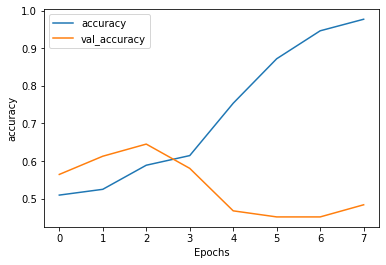

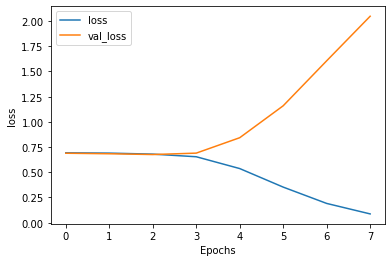

In [23]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

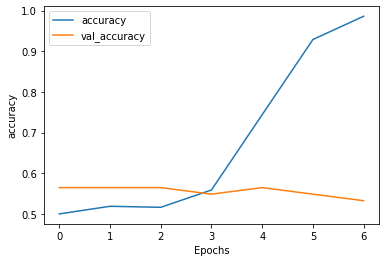

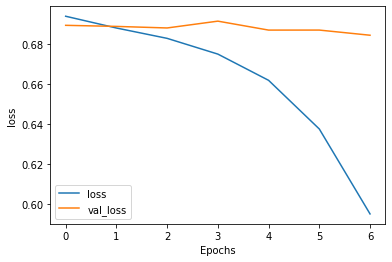

In [24]:
plot_graphs(history_2, 'accuracy')
plot_graphs(history_2, 'loss')

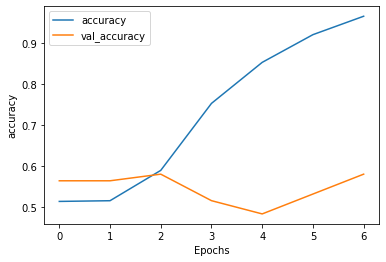

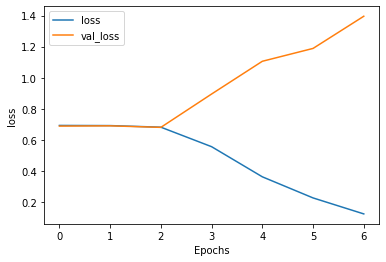

In [25]:
plot_graphs(history_3, 'accuracy')
plot_graphs(history_3, 'loss')